# Omega Aragonite Escape Velocity Regional Comparison

# 10 year Moving Average every 2 years

In [1]:
import xgcm
import xarray as xr
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import cm
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from xhistogram.xarray import histogram

In [2]:
%matplotlib inline

In [3]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

## Surface k10 RCP85 Ensemble Average

In [4]:
# k10 Omega Arag for ensemble average (preprocessed)
directory = '~/chazbpei2020/data/processed/Omega_Arag/RCP85/'
filename = 'omega_arag_k10_ensAvg_1950_2100.nc'
oa_path = directory+filename
ds = xr.open_dataset(oa_path).rename({'XT_OCEAN': 'xt_ocean',
                                     'YT_OCEAN': 'yt_ocean',
                                     'TIME': 'time',
                                     'OMEGA_ARAG': 'omega_arag'})

---

## Decadal Mean Omega Arag

In [5]:
# Calculate the time-mean Omega Arag throughout the simulation
da_oa_annual = ds.omega_arag.groupby('time.year').mean(dim='time', skipna=True)

startyear = 1950  # starting year
endyear = 2100  # ending year
interval = 10  # take mean over interval years
yearstep = 2   # take mean every yearstep years
buffer = interval // yearstep  # skip buffer years for decadal contours
da_oa_mean = moving_avg(da_oa_annual, startyear, endyear, 
                        interval, yearstep=yearstep)

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [6]:
len(da_oa_mean)

71

# Calculate Escape Vectors

In [7]:
# Definte projection transformations and coordiantes
crs = ccrs.Robinson(central_longitude=180)
src=ccrs.PlateCarree()
lon = ds.xt_ocean.data
lat = ds.yt_ocean.data

colors = ['hotpink','magenta','darkviolet','darkblue','blue',
          'dodgerblue','turquoise','limegreen','lime','gold',
          'darkorange','orangered','red','brown','maroon']

# Create levels array to isolate undersaturation threshold
clevs=[1]

## Plot undersaturation borders

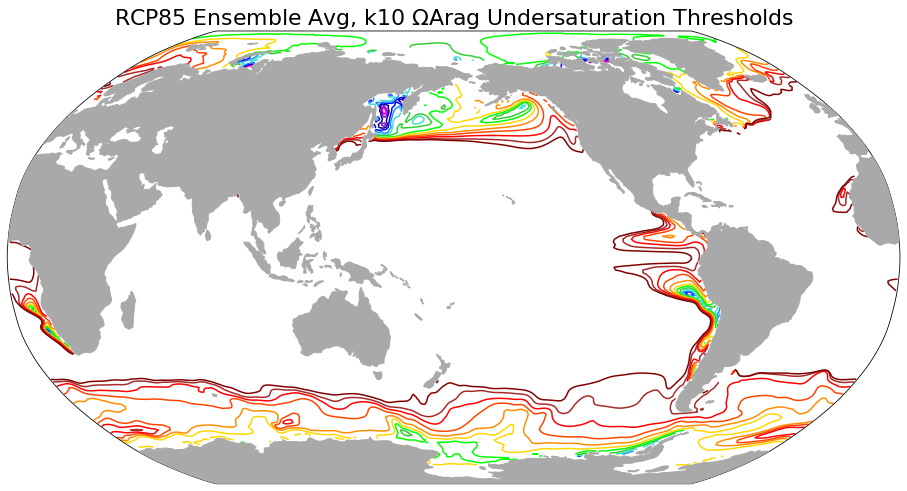

In [8]:
# Plot Velocities at undersaturation border for every 2 years
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})

num_contours = len(da_oa_mean)
num_colors = len(colors)
year=startyear
legend_elements = []
# Create legend for plots
for i in range(num_contours):
    element = Patch(facecolor=colors[i%num_colors], label=str(year))
    legend_elements.append(element)
    year+=yearstep
    
# Plot contours for each decade (skip buffer years for decadal contours)
c = 0
for i in range(0, num_contours, buffer):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[c%num_colors],transform=src)
    c += 1
# ax.legend(handles=legend_elements, loc='center')
ax.set_global()

ax.set_title('RCP85 Ensemble Avg, k10 $\Omega$Arag Undersaturation Thresholds',fontsize=22)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

fig.savefig('./oa_escvel_movingavg_figs/oa_k10_2yrstep_contour')

## Get points along contours

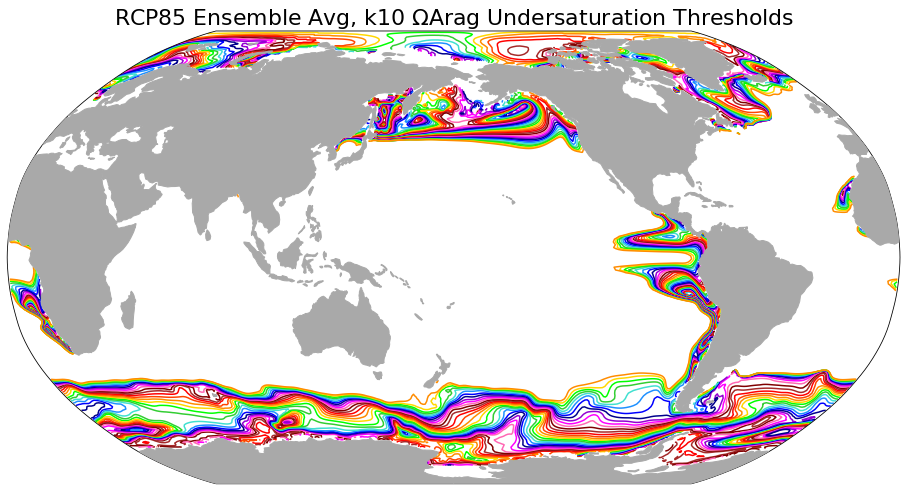

In [9]:
# Calculate Velocities at undersaturation border for every 2 years
fig, ax = plt.subplots(figsize=[16,10],
                               subplot_kw={'projection':crs})
    
# Extract points from contour line segments for each decade
list_xpoints = []  # list contianing lists of x points for each decade
list_ypoints = []  # list contianing lists of y points for each decade
for i in range(0, num_contours):
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[i%num_colors],transform=src)
    
    segments = cs.allsegs[0]
    num_segs = len(segments)
    
    xpoints = []  # to track multiple paths within same decade
    ypoints = []
    for j in range(num_segs):
        x = segments[j][:,0].tolist()  # convert to list to be easily concatenated
        y = segments[j][:,1].tolist()
        for p in x:
            xpoints.append(p)
        for p in y:
            ypoints.append(p)
    list_xpoints.append(xpoints)  # add list of x points for each decade
    list_ypoints.append(ypoints)  # add list of y points for each decade

# ax.legend(handles=legend_elements, loc='center')
ax.set_global()

ax.set_title('RCP85 Ensemble Avg, k10 $\Omega$Arag Undersaturation Thresholds',fontsize=22)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

In [10]:
# Round all values to nearest 0.5 (to be easily indexed)
# Create adjusted list to use later for indexing
list_xpoints_idx = []
list_ypoints_idx = []
for i in range(num_contours):  # list of lists
    xpoints = list_xpoints[i]  # individual list of xpoints
    ypoints = list_ypoints[i]  # individual list of ypoints
    num_points = len(xpoints)
    for p in range(num_points):
        xpoints[p] = round_half(xpoints[p])
        ypoints[p] = round_half(ypoints[p])
    xpoints = (np.array(xpoints)-0.5).tolist()
    ypoints = (np.array(ypoints)+89.5).tolist()
    
    list_xpoints_idx.append(xpoints)
    list_ypoints_idx.append(ypoints)

In [11]:
# For each contour, compute the minimum distance to the contour at
# the end of the interval

# Create parallel arrays of list to hold lists of directions and vectors for each decade
list_vector_dx = []  # dx for nearest points
list_vector_dy = []  # dy for nearest points
list_vector_magnitude = []  # distance to nearest points

for i in range(0, num_contours-buffer):
    vector_dx = []  # change in x for decade
    vector_dy = []  # change in y for decade
    vector_magnitude = []  # vector magnitude for decade
    xpoints = list_xpoints[i]  # x coords for decade
    ypoints = list_ypoints[i]  # y coords for decade
    num_points = len(xpoints)
    # For each point, find min dist and closest point on contour 
    # at the end of the time interval (one decade later)
    for p in range(num_points):
        xp = xpoints[p] # x value along contour
        yp = ypoints[p] # y value along contour
        x,y,dx,dy,mindist = min_dist(xp,yp,
                                     list_xpoints[i+buffer],
                                     list_ypoints[i+buffer],
                                    da_oa_mean[i].data)
        # maintain lists of x and y vectors
        vector_dx.append(dx/1000)
        vector_dy.append(dy/1000)
        vector_magnitude.append(mindist/1000)  # dist magnitude
    
    list_vector_dx.append(vector_dx)
    list_vector_dy.append(vector_dy)
    list_vector_magnitude.append(vector_magnitude)

In [12]:
# Reformat data to be Mappable
nx = len(lon)
ny = len(lat)
da_escape_dist = []  # escape distances for each decade
da_escape_dx = []  # escape dx for each decade
da_escape_dy = []  # escape dy for each decade
# For each time interval
for i in range(0,num_contours-buffer):
    # Create empty arrays and initialize all values to np.nan
    da_dx = np.zeros(shape=(nx,ny))
    da_dx[:,:] = np.nan
    da_dy = np.zeros(shape=(nx,ny))
    da_dy[:,:] = np.nan
    da_dist = np.zeros(shape=(nx,ny))
    da_dist[:,:] = np.nan
    # Iterate through points in array of contour point indices
    x_idx = list_xpoints_idx[i]
    y_idx = list_ypoints_idx[i]
    dx_vals = list_vector_dx[i]
    dy_vals = list_vector_dy[i]
    dist_vals = list_vector_magnitude[i]
    # For each contour point in the decade, save the escape vector
    # magnitude and direction in parallel DataArrays
    num_points = len(x_idx)
    for p in range(num_points):
        xi = int(x_idx[p])
        yi = int(y_idx[p])
        da_dx[xi,yi] = dx_vals[p]
        da_dy[xi,yi] = dy_vals[p]
        da_dist[xi,yi] = dist_vals[p]
    
    # Save out the vector (directionality and magnitude) fields as maps 
    # for each decade  
    da_dx = xr.DataArray(da_dx, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dx = da_dx.where(da_dx < np.inf)
    da_escape_dx.append(da_dx)
    da_dy = xr.DataArray(da_dy, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dy = da_dy.where(da_dy < np.inf)
    da_escape_dy.append(da_dy)
    da_dist = xr.DataArray(da_dist, dims=['xt_ocean','yt_ocean'], coords=[lon,lat]).T
    da_dist = da_dist.where(da_dist < np.inf)
    da_escape_dist.append(da_dist)

/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in less
  u, v = self.projection.transform_vectors(t, x, y, u, v)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1841: RuntimeWarning: invalid value encountered in greater
  u, v = self.projection.transform_vectors(t, x, y, u, v)


/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/matplotlib/quiver.py:697: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/matplotlib/quiver.py:767: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/matplotlib/quiver.py:780: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength
/home/aos/chazb/miniconda3/envs/chazbpei2020/lib/python3.8/site-packages/matplotlib/quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/aos/chazb/miniconda3/envs

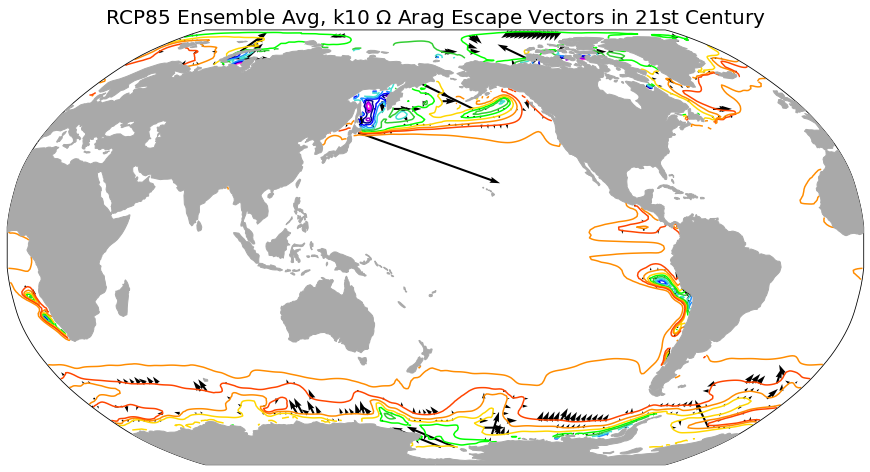

In [13]:
# Map escape vectors for all timestamps
crs = ccrs.Robinson(central_longitude=180)
fig, ax = plt.subplots(figsize=[16,8],
                               subplot_kw={'projection':crs})

# Create meshgrid for arrow plotting
X,Y = np.meshgrid(np.arange(360), np.arange(-90,90))
X = X+0.5
Y = Y+0.5
n=3

# Contours up to 'interval' years before end of simulation
c=0
for i in range(0, num_contours-interval-1, buffer):
#     i = i*2
    # Plot Omega Arag undersaturation contours for each decade
    cs = ax.contour(lon,lat,da_oa_mean[i],levels=clevs,
                    colors=colors[c%num_colors],transform=src)
    c+=1
    # Plot escape vectors
    U = da_escape_dx[i].data
    V = da_escape_dy[i].data
#     # Can ormalize vectors to plot arrows of constant size
#     N = np.sqrt(U**2 + V**2)
#     U = U/N
#     V = V/N
    ax.quiver(X[::n,::n], Y[::n,::n], U[::n,::n], V[::n,::n], transform=src)

# Plot final decade contour 
cs = ax.contour(lon,lat,da_oa_mean[num_contours-1],levels=clevs,
                    colors=colors[i%num_colors],transform=src)

ax.set_title('RCP85 Ensemble Avg, k10 $\Omega$ Arag Escape Vectors in 21st Century',
             fontsize=20)
ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')

---

## Calculate Escape Velocity

In [14]:
# Calculate escape velocity and create DataArray
nx = len(lon)
ny = len(lat)
year=1950
da_escape_vel = []
for i in range(num_contours-buffer):
    da_vel = (da_escape_dist[i]).copy().rename('Escape Velocity - '+str(year))
    da_escape_vel.append(da_vel)
    year+=yearstep

In [15]:
# # Comparison test
# da_escape_vel[14][140]

___

## Differentiate Regions

In [16]:
da_escvel_arctic = []  # Arctic ocean
da_escvel_equatorial = []  # Equatorial region
da_escvel_southern = []  # Southern ocean
for i in range(num_contours-buffer):
    da_escvel_arctic.append(da_escape_vel[i].loc[35:90,:].copy())
    da_escvel_equatorial.append(da_escape_vel[i].loc[-40:35,:].copy())
    da_escvel_southern.append(da_escape_vel[i].loc[-90:-40,:].copy())

In [17]:
# Define bin range and interval size
xlim = 1501
step = 150
levels = np.arange(0, xlim, step)
bins = np.array(levels)

In [18]:
%reload_ext autoreload
%autoreload 2
from chazbpei2020.preprocessing import *

In [19]:
# Calculate average Escape Velocities Distributions for different time periods
levels = np.arange(0, xlim, step)
bins = np.array(levels)
mid = num_contours//2
end = num_contours-buffer

# da_escvel_equatorial
arctic_historic_mean = hist_mean(da_escvel_arctic, levels, 0, mid)
arctic_future_mean = hist_mean(da_escvel_arctic, levels, mid, end)

# da_escvel_equatorial
equatorial_historic_mean = hist_mean(da_escvel_equatorial, levels, 0, mid)
equatorial_future_mean = hist_mean(da_escvel_equatorial, levels, mid, end)

# da_escvel_southern
southern_historic_mean = hist_mean(da_escvel_equatorial, levels, 0, mid)
southern_future_mean = hist_mean(da_escvel_southern, levels, mid, end)

# da_escape_vel
global_historic_mean = hist_mean(da_escape_vel, levels, 0, mid)
global_future_mean = hist_mean(da_escape_vel, levels, mid, end)

In [21]:
# Create DataArrays for entire earth and individual regions
arctic_historic_mean = xr.DataArray(arctic_historic_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('arctic_hist')
arctic_future_mean = xr.DataArray(arctic_future_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('arctic_future')
equatorial_historic_mean = xr.DataArray(equatorial_historic_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('equatorial_hist')
equatorial_future_mean = xr.DataArray(equatorial_future_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('equatorial_future')
southern_historic_mean = xr.DataArray(southern_historic_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('southern_hist')
southern_future_mean = xr.DataArray(southern_future_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('southern_future')
global_historic_mean = xr.DataArray(southern_historic_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('global_hist')
global_future_mean = xr.DataArray(global_future_mean, dims=['bin_edges'], 
                                    coords=[np.delete(bins,len(bins)-1)]).rename('global_future')

In [22]:
# Define Legend and colormap
colorcmp = ['plum','darkviolet',
            'orange','orangered',
            'lawngreen','limegreen']
regions = ['Arctic (Historical)','Arctic (Future)',
           'Equatorial (Historical)','Equatorial (Future)',
          'Southern (Historical)','Southern (Future)']
legend_elements = []
num_colors = len(colorcmp)
for i in range(num_colors):
    element = Patch(facecolor=colorcmp[i], label=regions[i])
    legend_elements.append(element)

<ipython-input-23-9a434396f69f>:8: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  d = scipy.zeros(num_bins)


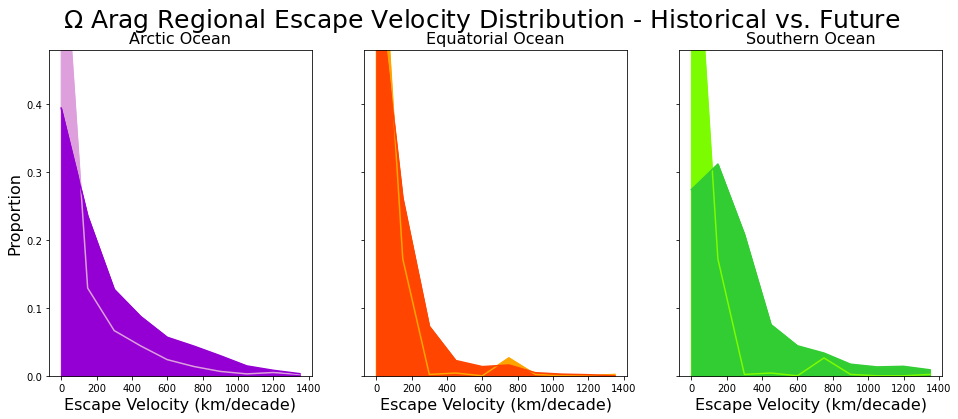

In [23]:
# Create Histograms for Different Regions' Escape Velocities
nrows=1
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6], 
                        sharex=True,sharey=True)

num_bins = len(levels)-1
d = scipy.zeros(num_bins)
xs = np.arange(0,xlim-1,step)

# Arctic
ax = axs[0]
ys = arctic_historic_mean
ys.plot(ax=axs[0],color=colorcmp[0])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[0])
ys = arctic_future_mean
ys.plot(ax=ax,color=colorcmp[1])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[1])
ax.set_title('Arctic Ocean',fontsize=16)

# Equatorial
ax = axs[1]
ys = equatorial_historic_mean
ys.plot(ax=ax,color=colorcmp[2])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[2])
ys = equatorial_future_mean
ys.plot(ax=ax,color=colorcmp[3])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[3])
ax.set_title('Equatorial Ocean',fontsize=16)

# Southern
ax = axs[2]
ys = southern_historic_mean
ys.plot(ax=ax,color=colorcmp[4])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[4])
ys = southern_future_mean
ys.plot(ax=ax,color=colorcmp[5])
ax.fill_between(xs, ys, where=ys>=d, interpolate=True, color=colorcmp[5])
ax.set_title('Southern Ocean',fontsize=16)

for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion',fontsize=16)
    ax.set_ylim(0,0.48)
    ax.label_outer()
    
    fig.suptitle('$\Omega$ Arag Regional Escape Velocity Distribution - Historical vs. Future',
                fontsize=25)
    

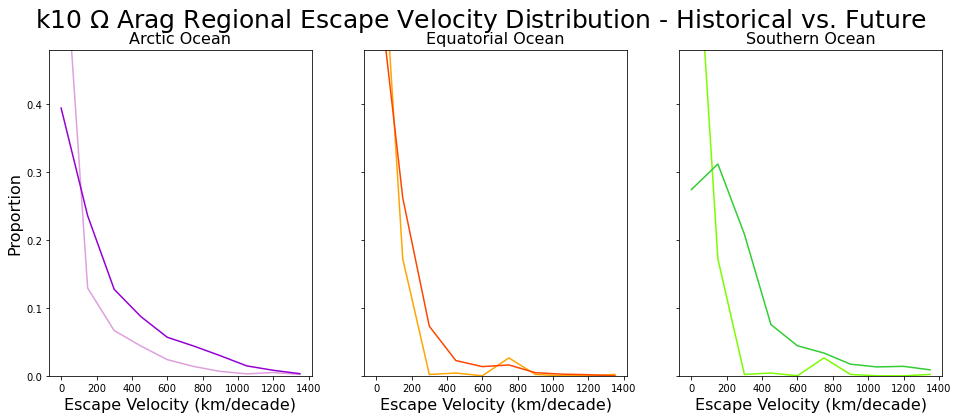

In [24]:
# Create Histograms for Different Regions' Escape Velocities
nrows=1
ncols=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[16,6], 
                        sharex=True,sharey=True)
# Arctic
ax = axs[0]
arctic_historic_mean.plot(ax=axs[0],color=colorcmp[0])
arctic_future_mean.plot(ax=ax,color=colorcmp[1])
ax.set_title('Arctic Ocean',fontsize=16)
# Equatorial
ax = axs[1]
equatorial_historic_mean.plot(ax=ax,color=colorcmp[2])
equatorial_future_mean.plot(ax=ax,color=colorcmp[3])
ax.set_title('Equatorial Ocean',fontsize=16)
# Southern
ax = axs[2]
southern_historic_mean.plot(ax=ax,color=colorcmp[4])
southern_future_mean.plot(ax=ax,color=colorcmp[5])

ax.set_title('Southern Ocean',fontsize=16)

for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion', fontsize=16)
    ax.set_ylim(0,0.48)
    ax.label_outer()
    
    fig.suptitle('k10 $\Omega$ Arag Regional Escape Velocity Distribution - Historical vs. Future',
                fontsize=25)

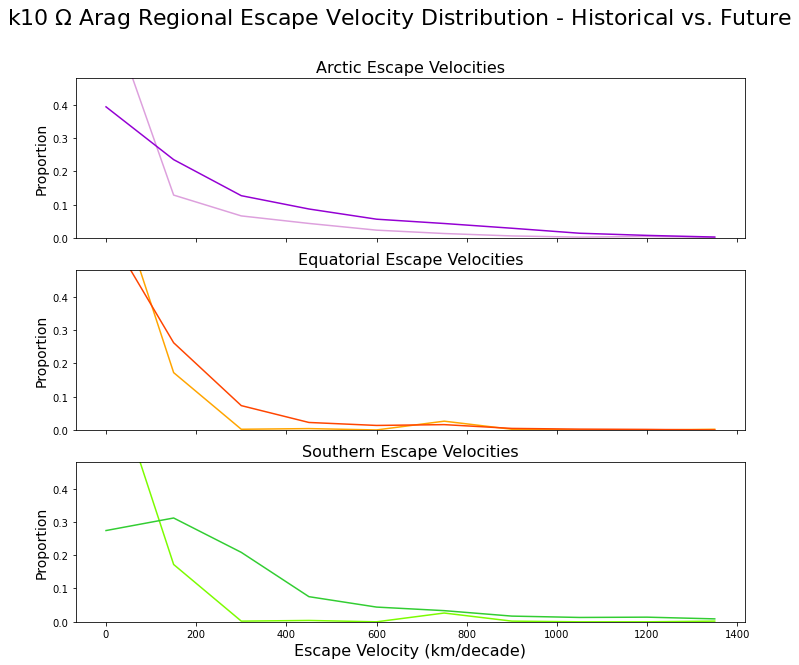

In [25]:
# Create Histograms for Different Regions' Escape Velocities
nrows=3
ncols=1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=[12,10], 
                        sharex=True,sharey=True)
# Arctic
ax = axs[0]
arctic_historic_mean.plot(ax=axs[0],color=colorcmp[0])
arctic_future_mean.plot(ax=ax,color=colorcmp[1])
ax.set_title('Arctic Escape Velocities',fontsize=16)
# Equatorial
ax = axs[1]
equatorial_historic_mean.plot(ax=ax,color=colorcmp[2])
equatorial_future_mean.plot(ax=ax,color=colorcmp[3])
ax.set_title('Equatorial Escape Velocities',fontsize=16)
# Southern
ax = axs[2]
southern_historic_mean.plot(ax=ax,color=colorcmp[4])
southern_future_mean.plot(ax=ax,color=colorcmp[5])

ax.set_title('Southern Escape Velocities',fontsize=16)

i=0
for ax in axs:
    ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
    ax.set_ylabel('Proportion',fontsize=14)
    ax.set_ylim(0,0.48)
    ax.label_outer()
#     ax.legend(handles=legend_elements[i:i+2], loc='upper right')
    i+=2
    
    fig.suptitle('k10 $\Omega$ Arag Regional Escape Velocity Distribution - Historical vs. Future',
                fontsize=22)

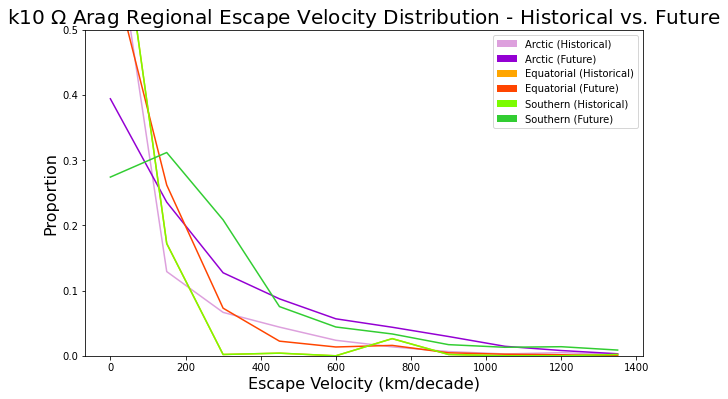

In [26]:
# Create Histogram for Different Regions' Escape Velocities (single plot)
fig, ax = plt.subplots(figsize=[10,6], 
                        sharex=True,sharey=True)

arctic_historic_mean.plot(ax=ax,color=colorcmp[0])
arctic_future_mean.plot(ax=ax,color=colorcmp[1])
equatorial_historic_mean.plot(ax=ax,color=colorcmp[2])
equatorial_future_mean.plot(ax=ax,color=colorcmp[3])
southern_historic_mean.plot(ax=ax,color=colorcmp[4])
southern_future_mean.plot(ax=ax,color=colorcmp[5])

ax.set_title('k10 $\Omega$ Arag Regional Escape Velocity Distribution - Historical vs. Future',
             fontsize=20)
ax.set_xlabel('Escape Velocity (km/decade)',fontsize=16)
ax.set_ylim(0,0.5)
ax.set_ylabel('Proportion',fontsize=16)
ax.label_outer()
ax.legend(handles=legend_elements, loc='upper right')

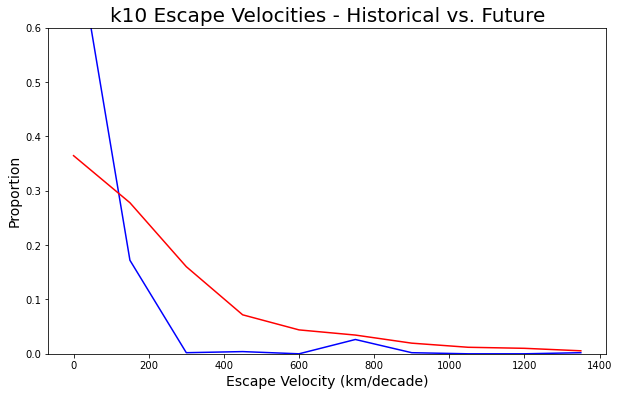

In [27]:
# Create Histogram for Different Regions' Escape Velocities (single plot)
fig, ax = plt.subplots(figsize=[10,6], 
                        sharex=True,sharey=True)

global_historic_mean.plot(ax=ax,color='b')
global_future_mean.plot(ax=ax,color='r')

ax.set_title('k10 Escape Velocities - Historical vs. Future',fontsize=20)
ax.set_xlabel('Escape Velocity (km/decade)',fontsize=14)
ax.set_ylim(0,0.6)
ax.set_ylabel('Proportion',fontsize=14)
ax.label_outer()

In [28]:
## Problem: Distance calculations need to be more precise!!!!!!